In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q accelerate
!pip install -q bitsandbytes
!pip install -q langchain
!pip install -q sentence-transformers
!pip install -q faiss-gpu
!pip install -q openpyxl
!pip install -q pacmap
!pip install -q openai
!pip install -q ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [1]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

### Load your knowledge base


In [2]:
from datasets import load_dataset

dataset = load_dataset("m-ric/huggingface_doc", split="train")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['text', 'source'],
    num_rows: 2647
})

In [3]:
from tqdm.notebook import tqdm
from langchain.docstore.document import Document

RAW_KNOWLEDGE_BASE = [Document(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(dataset)]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [4]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

### Retriever - embeddings

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    ""]

chunk_size=1000
chunk_overlap = int(chunk_size/10)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, # the maximum number of characters in a chunk: we selected this value arbitrarily
                                               chunk_overlap=chunk_overlap, # the number of characters to overlap between chunks
                                               add_start_index=True, # If `True`, includes chunk's start index in metadata,
                                               strip_whitespace=True, # If `True`, strips whitespace from the start and end of every document
                                               separators=MARKDOWN_SEPARATORS)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [6]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

Model's maximum sequence length: 512


In [7]:
len(docs_processed)

31085

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

  0%|          | 0/31085 [00:00<?, ?it/s]

In [9]:
import numpy as np

min(lengths), np.median(lengths), np.mean(lengths), max(lengths)

(3, 218.0, 216.25185780923275, 999)

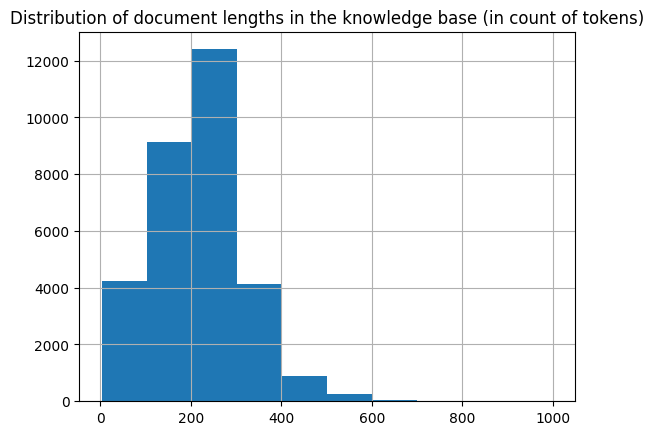

In [10]:
from matplotlib import pyplot as plt

# Plot the distrubution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from typing import List, Optional


def split_documents(chunk_size:int,
                    knowledge_base: List[Document],
                    tokenizer_name: Optional[str]=EMBEDDING_MODEL_NAME) -> List[Document]:

    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(tokenizer,
                                                                              chunk_size=chunk_size,
                                                                              chunk_overlap=int(chunk_size/10),
                                                                              add_start_index=True,
                                                                              strip_whitespace=True,
                                                                              separators=MARKDOWN_SEPARATORS)

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unqique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unqique.append(doc)

    return docs_processed_unqique

In [12]:
docs_processed = split_documents(512, # We choose a chunk size adapted to our model
                                 RAW_KNOWLEDGE_BASE,
                                 tokenizer_name=EMBEDDING_MODEL_NAME)



In [13]:
docs_processed

[Document(page_content='Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\

  0%|          | 0/17995 [00:00<?, ?it/s]

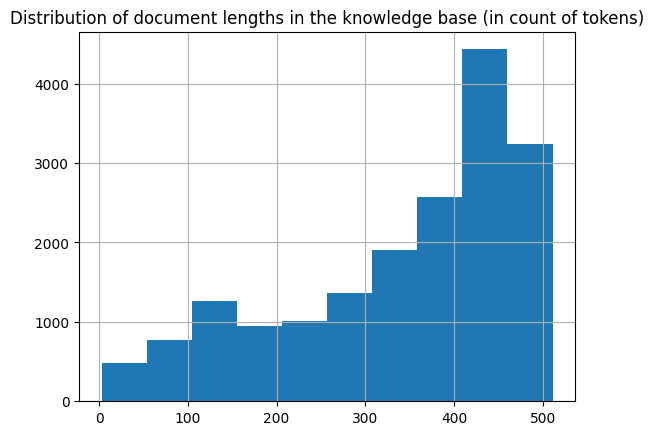

In [14]:
# Let's visualize the chunk sizes we would have in tokens from a common model

tokneizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokneizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### Building the vector database

In [15]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME,
                                        multi_process=True,
                                        model_kwargs={"device": "cuda"},
                                        encode_kwargs={"normalize_embeddings": True} # set True for cosine similarity
                                        )

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(docs_processed,
                                                 embedding_model,
                                                 distance_strategy=DistanceStrategy.COSINE)

In [16]:
# embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [17]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=3,
                                    n_neighbors=None,
                                    MN_ratio=0.5,
                                    FP_ratio=2.0,
                                    random_state=2)

embeddings_3d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
    ] + [query_vector]

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 2
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [18]:
# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_3d), init="pca")

In [19]:
docs_processed[0]

Document(page_content='Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\n

In [20]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "z": documents_projected[i, 2],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 10
        }
        for i in range(len(docs_processed))
    ]
    +
    [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "z": documents_projected[-1, 2],
            "source": "User query",
            "extract": user_query,
            "size_col": 10,
            "symbol": "star"
        }
    ]
)

In [21]:
# visualize the embedding
fig = px.scatter_3d(df,
                    x="x",
                    y="y",
                    z="z",
                    color="source",
                    hover_data="extract",
                    size="size_col",
                    symbol="symbol",
                    color_discrete_map={"User query": "black"},
                    width=1000,
                    height=700)

fig.update_traces(marker=dict(opacity=1,
                              line=dict(width=0, color="DarkSlateGrey")),
                  selector=dict(mode="markers"))
fig.update_layout(legend_title_text="<b>Chunk source</b>",
                  title="<b>3D Projection of Chunk Embeddings via PaCMAP</b>")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [21]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


### Reader - LLM

In [22]:
import torch
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

bnb_config = BitsAndBytesConfig(load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type="nf4",
                                bnb_4bit_compute_dtype=torch.bfloat16)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME,
                                             quantization_config=bnb_config)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(model=model,
                      tokenizer=tokenizer,
                      task="text-generation",
                      do_sample=True,
                      temperature=0.2,
                      repetition_penalty=1.1,
                      return_full_text=False,
                      max_new_tokens=512)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
READER_LLM("What is 4+4? Answer:")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': ' 8'}]

### Prompt

In [24]:
# prompt_in_chat_format = [
#     {
#         "role": "system",
#         "content": """Using the information contained in the context,
# give a comprehensive answer to the question.
# Respond only to the question asked, response should be concise and relevant to the question.
# Provide the number of the source document when relevant.
# If the answer cannot be deduced from the context, do not give an answer.""",
#     },
#     {
#         "role": "user",
#         "content": """Context:
# {context}
# ---
# Now here is the question you need to answer.

# Question: {question}""",
#     },
# ]

prompt_in_chat_format = [
    {
        "role": "user",
        "content": """Context:
# {context}
# ---
# Now here is the question you need to answer.

# Question: {question}""",
    },
    {
        "role": "assistant",
        "content": """Using the information contained in the context,
# give a comprehensive answer to the question.
# Respond only to the question asked, response should be concise and relevant to the question.
# Provide the number of the source document when relevant.
# If the answer cannot be deduced from the context, do not give an answer.""",
    }
]


RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(prompt_in_chat_format,
                                                    tokenize=False,
                                                    add_generation_prompt=True)
print(RAG_PROMPT_TEMPLATE)

<s>[INST] Context:
# {context}
# ---
# Now here is the question you need to answer.

# Question: {question} [/INST]Using the information contained in the context,
# give a comprehensive answer to the question.
# Respond only to the question asked, response should be concise and relevant to the question.
# Provide the number of the source document when relevant.
# If the answer cannot be deduced from the context, do not give an answer.</s> 


In [25]:
len(docs_processed)

17995

In [27]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
    ] # we only need the text of the documents

context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?",
    context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




To create a custom pipeline, you need to decide the raw entries the pipeline will be able to take. These inputs should be as pure Python as possible. Then define the outputs. Start by inheriting the base class `Pipeline` with the four methods needed to implement `preprocess`, `_forward`, `postprocess`, and `_sanitize_parameters`.


In [28]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Assembling it all

In [29]:
from transformers import Pipeline
from typing import Tuple

def answer_with_rag(question: str,
                    llm: Pipeline,
                    knowledge_index: FAISS,
                    reranker: Optional[RAGPretrainedModel]=None,
                    num_retrieved_docs: int=30,
                    num_docs_final: int=5)-> Tuple[str, List[Document]]:

    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs] # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer ...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [31]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(question,
                                        READER_LLM,
                                        KNOWLEDGE_VECTOR_DATABASE,
                                        reranker=RERANKER)

=> Retrieving documents...
=> Reranking documents...
Your documents are roughly 226.1 tokens long at the 90th percentile! This is quite long and might slow down reranking!
 Provide fewer documents, build smaller chunks or run on GPU if it takes too long for your needs!
Your documents are roughly 226.1 tokens long at the 90th percentile! This is quite long and might slow down reranking!
 Provide fewer documents, build smaller chunks or run on GPU if it takes too long for your needs!


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=> Generating answer ...


In [32]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================


To create a pipeline object, you need to first allocate a pipeline for the task you want to perform. This can be done using the `pipeline()` function and specifying the name of the task. Once you have allocated a pipeline, you can pass an image to the pipeline using the `pipeline()` function again, followed by the image itself. The output of the pipeline will be a list of objects containing information about the detected objects in the image.

For example, if you want to detect objects in an image, you could allocate a pipeline for object detection using the following code:
```python
object_detector = pipeline('object-detection')
```
You can then pass an image to the pipeline using the following code:
```python
image = object_detector(image)
```
The output of the pipeline will be a list of objects containing information about the detected objects in the image.

This process is described in detail in Document 0